<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Import the packege

In [2]:
import shap
import time
import logging
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder , LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV, SelectFromModel
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import wilcoxon, bootstrap
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from scipy.stats import wilcoxon, bootstrap, uniform, randint

import joblib
import os
import tensorflow

In [3]:
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
SEED = 42
np.random.seed(SEED)

In [4]:
df = pd.read_csv('../../data/train.csv')

In [5]:
df = df.drop('id', axis=1)

In [6]:
df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 51.5+ MB


In [10]:
numeric_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

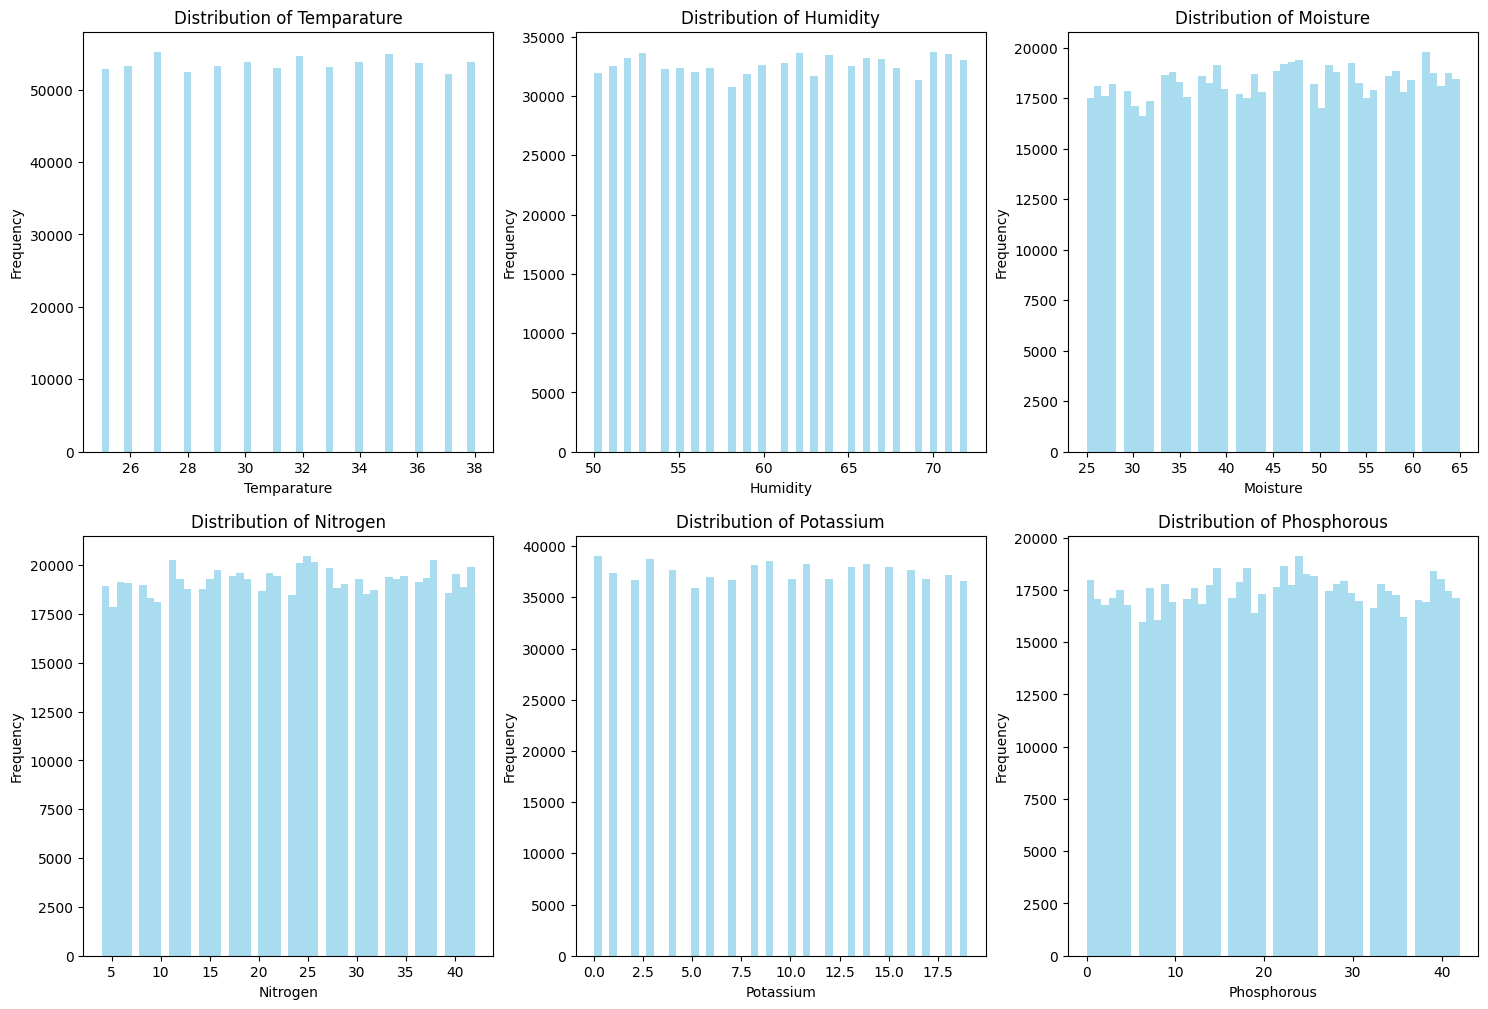

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, col in enumerate(numeric_cols):
	row, col_idx = i // 3, i % 3
	axes[row, col_idx].hist(df[col], bins=50, alpha=0.7, color='skyblue')
	axes[row, col_idx].set_title(f'Distribution of {col}')
	axes[row, col_idx].set_xlabel(col)
	axes[row, col_idx].set_ylabel('Frequency')

# ETL Pipeline for Agricultural Fertilizer Prediction Dataset

In [ ]:
class FertilizerETL:
    def __init__(self, df):
        self.df = df.copy()
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.target_encoder = LabelEncoder()
        
    def extract_and_explore(self):
        print('=== DATASET OVERVIEW ===')
        print(f'Dataset shape: {self.df.shape}')
        print(f'Memory Usage: {self.df.memory_usage(deep=True).sum()/1024*2:.2f} MB')
        print('\n=== DATA TYPES ===')
        print(self.df.dtype)
        
        
        print('\n=== MISSING VALUES ===')
        print(self.df.isnull().sum())
        
        
        print('\n===BASIC STATISTICS ===')
        print(self.df.describe())
        
        
        print("\n=== CATEGORICAL VARIABLES ANALYSIS ===")
        categorical_cols = ['Soil Type', 'Crop Type', 'Fertilizer Name']
        for col in categorical_cols:
            print(f"\n{col} - Unique values: {self.df[col].nunique()}")
            print(self.df[col].value_counts().head(10))
            
        return self.df
    
    
    
    def visualize_data(self):
        fig, axes = plt.Subplots(2, 3, figsize=(18,12))
        
        numeric_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
        
        for i, col in enumerate(numeric_cols):
            row, col_idx = i // 3, i % 3 
            
            
            
            
            
            
            
            
            